# Prediction of listing gains in the Indian IPO market

This project is based on and extends the work of [darinbradley @ DataQuest](https://github.com/dataquestio/solutions/blob/master/Mission798Solutions.ipynb)

In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error
from math import sqrt

In [89]:
# Reading in the data and getting started
df = pd.read_csv('Indian_IPO_Market_Data.csv')
print (df.shape)
df.head()

(319, 9)


,Date,IPOName,Issue_Size,Subscription_QIB,Subscription_HNI,Subscription_RII,Subscription_Total,Issue_Price,Listing_Gains_Percent
0,03/02/10,Infinite Comp,189.80,48.44,106.02,11.08,43.22,165,11.82
1,08/02/10,Jubilant Food,328.70,59.39,51.95,3.79,31.11,145,-84.21
2,15/02/10,Syncom Health,56.25,0.99,16.60,6.25,5.17,75,17.13
3,15/02/10,Vascon Engineer,199.80,1.12,3.65,0.62,1.22,165,-11.28
4,19/02/10,Thangamayil,0.00,0.52,1.52,2.26,1.12,75,-5.20


In [90]:
# Look at the variable of interest more carefully
df['Listing_Gains_Percent'].describe()

count    319.000000
mean       4.742696
std       47.650946
min      -97.150000
25%      -11.555000
50%        1.810000
75%       25.310000
max      270.400000
Name: Listing_Gains_Percent, dtype: float64

# Working with the data
## Training/Test split
Now we split the data into training and test sets (the usual 80/20 split). 80% for the training and 20% for testing

In [91]:
# First drop the columns that we won't use --> Date, Name
df = df.drop(['Date ', 'IPOName'], axis=1) # Note an extra space in 'Date '.

# Randomise the dataset
data_randomised = df.sample(frac = 1, random_state= 1)

# Calculate index for split at 80% of data
split_index = round(len(data_randomised) * 0.8 )

# Training/ test split at the split_index
training_data = data_randomised[ : split_index ].reset_index(drop=True)
test_data = data_randomised[ split_index: ].reset_index(drop=True)

print("Shape of training data is ", training_data.shape, " and the shape of test data is ", test_data.shape)

# Sanity check to see the listing_gains_percent in both training and test datasets has similar values or not
print (training_data['Listing_Gains_Percent'].describe())
print (test_data['Listing_Gains_Percent'].describe())

Shape of training data is  (255, 7)  and the shape of test data is  (64, 7)
count    255.000000
mean       4.086235
std       49.757586
min      -97.150000
25%      -11.555000
50%        1.110000
75%       23.340000
max      270.400000
Name: Listing_Gains_Percent, dtype: float64
count     64.000000
mean       7.358281
std       38.348751
min      -92.370000
25%      -11.860000
50%        6.260000
75%       29.567500
max      106.790000
Name: Listing_Gains_Percent, dtype: float64


Clearly there are significant differences in the statistics of the training and test datasets. This is likely due to presence of outliers in the data. We'll deal with this later.

## Exploring the data

In [92]:
# Check for any missing values or NaNs.
print (training_data.isnull().sum())
print (test_data.isnull().sum())

Issue_Size               0
Subscription_QIB         0
Subscription_HNI         0
Subscription_RII         0
Subscription_Total       0
Issue_Price              0
Listing_Gains_Percent    0
dtype: int64
Issue_Size               0
Subscription_QIB         0
Subscription_HNI         0
Subscription_RII         0
Subscription_Total       0
Issue_Price              0
Listing_Gains_Percent    0
dtype: int64


In [93]:
# Create a new column of profits to differentiate from losses
training_data['Listing_Gains_Profit'] = np.where( training_data['Listing_Gains_Percent'] > 0, 1, 0 )
print("Profits = 1 vs Losses = 0 in the IPO data as percentages: \n")
print( training_data['Listing_Gains_Profit'].value_counts(normalize=True))


Profits = 1 vs Losses = 0 in the IPO data as percentages: 

Listing_Gains_Profit
1    0.537255
0    0.462745
Name: proportion, dtype: float64


## Data Visualisation
Visualise the key statistics of the training dataset

Text(0, 0.5, 'Count')

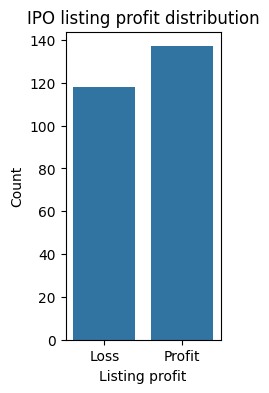

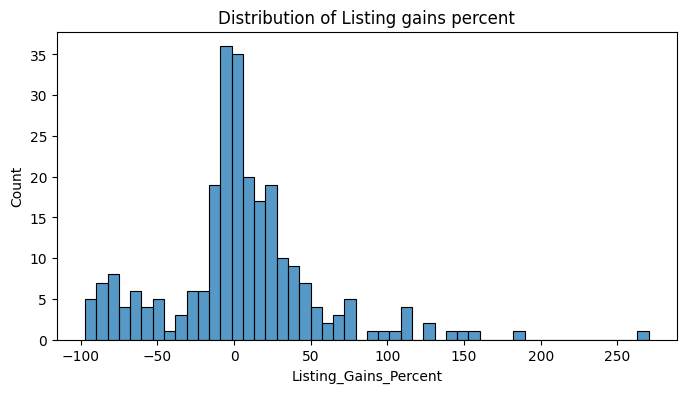

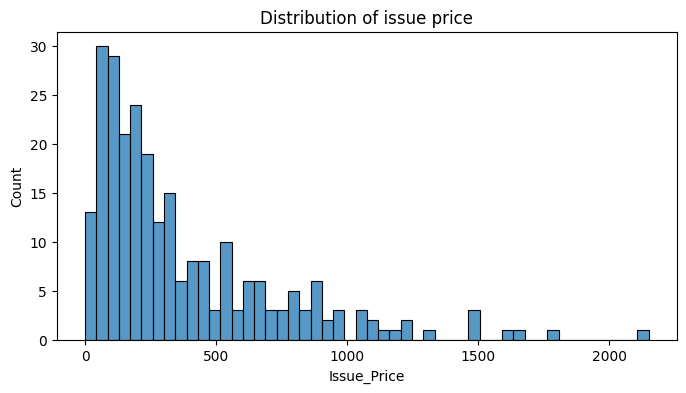

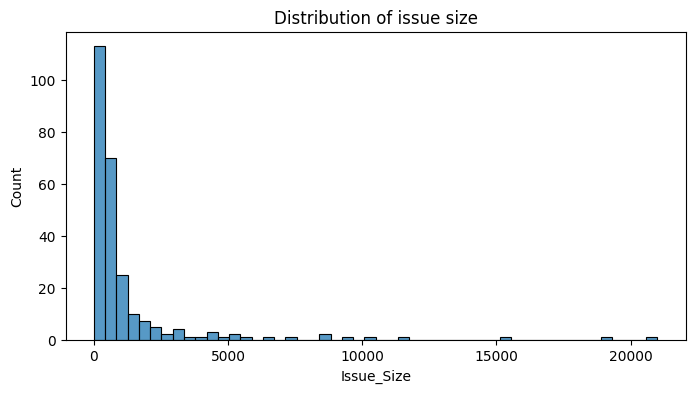

In [94]:
# Target variable = Listing_Gains_Profit
plt.figure(figsize= [2,4])
sns.countplot ( x = 'Listing_Gains_Profit', data = training_data )
plt.title('IPO listing profit distribution')
plt.ylabel('Count')
plt.xlabel('Listing profit')
plt.xticks(ticks = [0,1], labels = ['Loss', 'Profit'])

# Distribution of Listing gains percent
plt.figure(figsize= [8,4])
sns.histplot( data = training_data, x = 'Listing_Gains_Percent', bins = 50 )
plt.title('Distribution of Listing gains percent')
plt.ylabel('Count')

# Distribution of issue price
plt.figure(figsize= [8,4])
sns.histplot( data = training_data, x = 'Issue_Price', bins = 50 )
plt.title('Distribution of issue price')
plt.ylabel('Count')

# Distribution of issue size
plt.figure(figsize= [8,4])
sns.histplot( data = training_data, x = 'Issue_Size', bins = 50 )
plt.title('Distribution of issue size')
plt.ylabel('Count')




### Inference
From the visualisations above, we observe:
- There are similar number of profits and losses
- Histograms show that there are significant outliers in the data.
- Distribution is skewed.

We further check for correlations between different variables.

Text(0, 0.5, 'Issue Price')

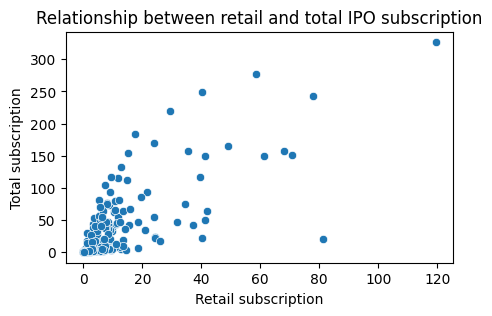

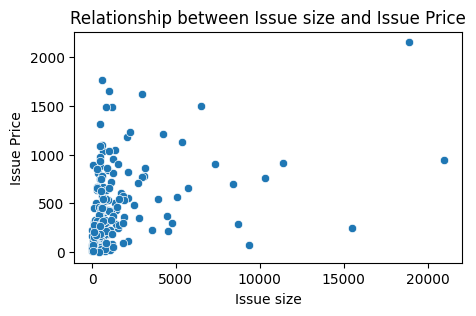

In [95]:
# Relationship between retail and total IPO subscription
plt.figure(figsize= [5,3])
sns.scatterplot(data = training_data, x = 'Subscription_RII', y = 'Subscription_Total' )
plt.title('Relationship between retail and total IPO subscription')
plt.xlabel('Retail subscription')
plt.ylabel('Total subscription')

# Relationship between Issue size and Issue price
plt.figure(figsize= [5,3])
sns.scatterplot(data = training_data, x = 'Issue_Size', y = 'Issue_Price' )
plt.title('Relationship between Issue size and Issue Price')
plt.xlabel('Issue size')
plt.ylabel('Issue Price')

### More inference
- There is a clear correlation between the retail and total IPO subscription.
- There is a weak correlation between issue size and issue price

### Outlier Treatment
We identify the upper and lower bounds for each column and use the df.clip() function to replace any outliers with the respective upper or lower bound.
The upper and lower bounds are based on the interquartile range (IQR) as described in the image below. IQR = Q3 - Q1.

![](iqrOutlier.png)

In [96]:
# Remove outliers from all the columns 
columns = ['Issue_Size', 'Subscription_QIB', 'Subscription_HNI', 'Subscription_RII', 'Subscription_Total', 'Issue_Price', 'Listing_Gains_Percent']

for column in columns:
    q1 = training_data[column].quantile(0.25)
    q3 = training_data[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5* iqr
    upper_bound = q3 + 1.5* iqr
    training_data[column] = training_data[column].clip(lower_bound, upper_bound)



Visualise the data again to see the effect of outlier treatment

Text(0, 0.5, 'Count')

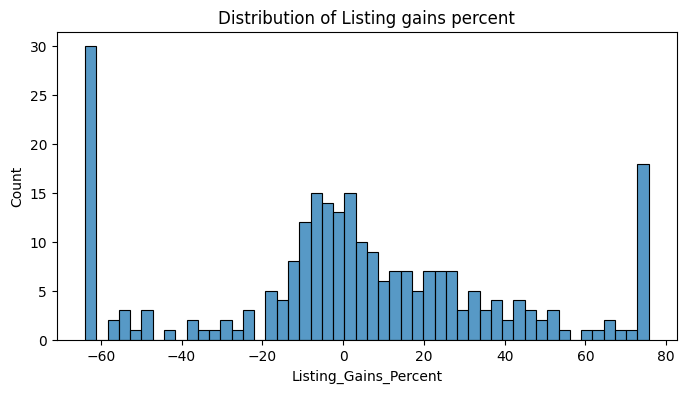

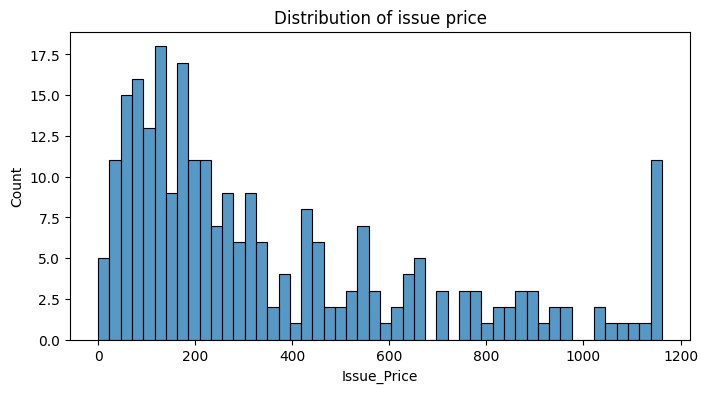

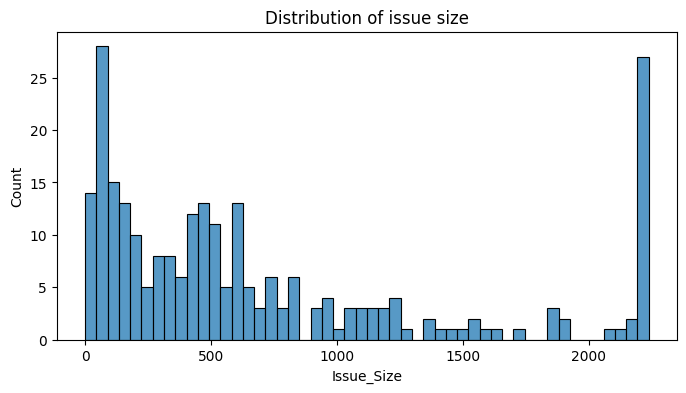

In [97]:
# Distribution of Listing gains percent
plt.figure(figsize= [8,4])
sns.histplot( data = training_data, x = 'Listing_Gains_Percent', bins = 50 )
plt.title('Distribution of Listing gains percent')
plt.ylabel('Count')

# Distribution of issue price
plt.figure(figsize= [8,4])
sns.histplot( data = training_data, x = 'Issue_Price', bins = 50 )
plt.title('Distribution of issue price')
plt.ylabel('Count')

# Distribution of issue size
plt.figure(figsize= [8,4])
sns.histplot( data = training_data, x = 'Issue_Size', bins = 50 )
plt.title('Distribution of issue size')
plt.ylabel('Count')

There is a clear problem here at the upper and lower bounds - too many outliers are detected and a huge amount of points accumulate at the two ends. This needs addressing in a future version of this code.

## Predictor and Target variables

We will use all the columns as features for training the ML model. At this point we are only interested in profit/loss, so we drop the 'Listing_Gains_percent' column. We also normalise all the features by scaling w.r.t. the maximum value.

In [98]:
target_variable = ['Listing_Gains_Profit']
predictors = list( set(list(training_data.columns)) - set(['Listing_Gains_Profit', 'Listing_Gains_Percent']))
training_data[predictors] = training_data[predictors]/ training_data[predictors].max()

# Extract the values into numpy arrays for X_train and Y_train
X_train = training_data[predictors].values
Y_train = training_data[target_variable].values

### Deep learning classification model
Define a suitable model for binary classification.


In [99]:
tf.random.set_seed(100)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(32, input_shape = (X_train.shape[1],), activation = 'relu'))
model.add(tf.keras.layers.Dense(16, activation= 'relu'))
model.add(tf.keras.layers.Dense(8, activation= 'relu'))
model.add(tf.keras.layers.Dense(4, activation= 'relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

/Users/prashant/Dropbox/Training/DS_SP/Core_DS_Projects/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compile and train the model


In [100]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
print (model.summary())

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 32)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 929 (3.63 KB)

 Trainable params: 929 (3.63 KB)

 Non-trainable params: 0 (0.00 B)

None


In [101]:
# Train the model on the training data
model.fit(X_train, Y_train, epochs = 2000)

Epoch 1/2000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5352 - loss: 0.6831  
Epoch 2/2000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5612 - loss: 0.6770
Epoch 3/2000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5985 - loss: 0.6708
Epoch 4/2000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6612 - loss: 0.6645
Epoch 5/2000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6763 - loss: 0.6580
Epoch 6/2000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6860 - loss: 0.6516
Epoch 7/2000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6846 - loss: 0.6455
Epoch 8/2000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6782 - loss: 0.6395
Epoch 9/2000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6798 - loss: 0.6341
Epoch 10/2000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6824 - loss: 0.6300 
Epoch 11/2000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6763 - loss: 0.6268 
Epoch 12/2000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6776 

Analysing the above output, it is clear that the model accuracy increases significantly with the number of epochs. After training over 200 epochs, we achieve an accurcy of close to 97%.

In [102]:
model.evaluate(X_train, Y_train)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9520 - loss: 0.0766 


[0.08332080394029617, 0.9529411792755127]

In [103]:
# Process the test data
test_data['Listing_Gains_Profit'] = np.where( test_data['Listing_Gains_Percent'] > 0, 1, 0 )
test_data[predictors] = test_data[predictors]/ test_data[predictors].max()
X_test = test_data[predictors].values
Y_test = test_data[target_variable].values

In [104]:
# Evaluate the model over test data
model.evaluate(X_test, Y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4062 - loss: 8.0912


[7.547397613525391, 0.421875]

Quite clearly this model performs very poorly over the test data. It is very likely that the above process has led to overfitting. It is also expected since there are 929 parameters and only 255 data points.
Let's try again by reducing the model size.

In [105]:
tf.random.set_seed(100)
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Dense(8, input_shape = (X_train.shape[1],), activation = 'relu'))
# model2.add(tf.keras.layers.Dense(16, activation= 'relu'))
# model2.add(tf.keras.layers.Dense(8, activation= 'relu'))
model2.add(tf.keras.layers.Dense(4, activation= 'relu'))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model2.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
print (model2.summary())

/Users/prashant/Dropbox/Training/DS_SP/Core_DS_Projects/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_29 (Dense)                │ (None, 8)              │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97 (388.00 B)

 Trainable params: 97 (388.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [106]:
# Train the model on the training data
model2.fit(X_train, Y_train, epochs = 300)

Epoch 1/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5352 - loss: 0.6942  
Epoch 2/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5352 - loss: 0.6930 
Epoch 3/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5352 - loss: 0.6920
Epoch 4/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5352 - loss: 0.6909
Epoch 5/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5352 - loss: 0.6898
Epoch 6/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5352 - loss: 0.6885
Epoch 7/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5352 - loss: 0.6871
Epoch 8/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5352 - loss: 0.6855
Epoch 9/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5352 - loss: 0.6836
Epoch 10/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5352 - loss: 0.6816
Epoch 11/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5352 - loss: 0.6794
Epoch 12/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5352 - loss: 0.677

In [107]:
# Check model performance
print ( model2.evaluate(X_train, Y_train) )
print ( model2.evaluate(X_test, Y_test) )


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7051 - loss: 0.5611 
[0.5873883366584778, 0.6823529601097107]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5729 - loss: 0.6547
[0.6683557629585266, 0.546875]


The performance is still not great.

Let's remove the outliers from the test data and see.

In [108]:

# Creating a new dataset to work with.
df2 = data_randomised
# Create a new column of profits to differentiate from losses
df2['Listing_Gains_Profit'] = np.where( df2['Listing_Gains_Percent'] > 0, 1, 0 )

# Remove outliers from the complete data and then split into training and test
columns = ['Issue_Size', 'Subscription_QIB', 'Subscription_HNI', 'Subscription_RII', 'Subscription_Total', 'Issue_Price', 'Listing_Gains_Percent']

for column in columns:
    q1 = df2[column].quantile(0.25)
    q3 = df2[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5* iqr
    upper_bound = q3 + 1.5* iqr
    df2[column] = df2[column].clip(lower_bound, upper_bound)

# Calculate index for split at 80% of data
split_index = round(len(data_randomised) * 0.8 )

# Training/ test split at the split_index
training_data = data_randomised[ : split_index ].reset_index(drop=True)
test_data = data_randomised[ split_index: ].reset_index(drop=True)

print("Shape of training data is ", training_data.shape, " and the shape of test data is ", test_data.shape)

# Extract the values into numpy arrays for training and validation
X_train = training_data[predictors].values
Y_train = training_data[target_variable].values
X_test = test_data[predictors].values
Y_test = test_data[target_variable].values


Shape of training data is  (255, 8)  and the shape of test data is  (64, 8)


In [109]:
# Train the model
model2.fit(X_train, Y_train, epochs = 300)

Epoch 1/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5402 - loss: 255.3048
Epoch 2/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5128 - loss: 108.4692 
Epoch 3/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5497 - loss: 73.8402 
Epoch 4/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5597 - loss: 41.3251 
Epoch 5/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5983 - loss: 32.0605 
Epoch 6/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6051 - loss: 20.6628 
Epoch 7/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6016 - loss: 20.6409 
Epoch 8/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5729 - loss: 16.6884 
Epoch 9/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5822 - loss: 14.8182 
Epoch 10/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6042 - loss: 13.1997 
Epoch 11/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6193 - loss: 11.8394 
Epoch 12/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 

In [110]:
# Check model performance
print ( model2.evaluate(X_train, Y_train) )
print ( model2.evaluate(X_test, Y_test) )

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6245 - loss: 1.0288 
[1.1711184978485107, 0.6000000238418579]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5625 - loss: 2.1315
[2.5143322944641113, 0.546875]


With all the three methods used above, accuracy doesn't rise beyond 55% which is quite poor.